# Set up

## Package Loading

In [1]:
import pandas as pd
import numpy as np
import itertools
#!pip install emoji
#!pip install imblearn
import emoji
import re
#!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, make_scorer
import matplotlib.pyplot as plt
import time
import joblib

#from google.colab import drive
#drive.mount('/content/drive')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/v.zevallosm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/v.zevallosm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Set Up paths

In [2]:
# Parent paths
google_path = '/content/drive/My Drive/'
local_path = '/home/v.zevallosm/detecting_harmful_content/'
parent_path = local_path

#Specific paths
path_train = parent_path+"data/external/Harmful/train_tweet.csv" 
path_test = parent_path+"data/external/Harmful/test_tweet.csv" 
path_preprocessed = parent_path+"data/processed/Harmful/train_tweet_preprocessed_final.csv" 

path_hyperparameters_sgd = parent_path+"models/English/Classical_approach/Harmful/Hyperparameters_Final/sgd.csv"
path_hyperparameters_svm = parent_path+"models/English/Classical_approach/Harmful/Hyperparameters_Final/svm.csv"
path_hyperparameters_et = parent_path+"models/English/Classical_approach/Harmful/Hyperparameters_Final/et.csv"
path_hyperparameters_rf = parent_path+"models/English/Classical_approach/Harmful/Hyperparameters_Final/rf.csv"
path_hyperparameters_nb = parent_path+"models/English/Classical_approach/Harmful/Hyperparameters_Final/nb.csv"
path_hyperparameters_knn = parent_path+"models/English/Classical_approach/Harmful/Hyperparameters_Final/knn.csv"
path_hyperparameters_lr = parent_path+"models/English/Classical_approach/Harmful/Hyperparameters_Final/lr.csv"
path_hyperparameters_dt = parent_path+"models/English/Classical_approach/Harmful/Hyperparameters_Final/dt.csv"

path_best_parameters_sgd = parent_path+"models/English/Classical_approach/Harmful/Hyperparameters_Final/best_parameters/sgd.pkl"
path_best_parameters_svm = parent_path+"models/English/Classical_approach/Harmful/Hyperparameters_Final/best_parameters/svm.pkl"
path_best_parameters_et = parent_path+"models/English/Classical_approach/Harmful/Hyperparameters_Final/best_parameters/et.pkl"
path_best_parameters_rf = parent_path+"models/English/Classical_approach/Harmful/Hyperparameters_Final/best_parameters/rf.pkl"
path_best_parameters_nb = parent_path+"models/English/Classical_approach/Harmful/Hyperparameters_Final/best_parameters/nb.pkl"
path_best_parameters_knn = parent_path+"models/English/Classical_approach/Harmful/Hyperparameters_Final/best_parameters/knn.pkl"
path_best_parameters_lr = parent_path+"models/English/Classical_approach/Harmful/Hyperparameters_Final/best_parameters/lr.pkl"
path_best_parameters_dt = parent_path+"models/English/Classical_approach/Harmful/Hyperparameters_Final/best_parameters/dt.pkl"


## Set Up Functions

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Balance Dataset

In [4]:
# loading preprocessd data
df = pd.read_csv(path_preprocessed)
df = df[df['text'].apply(lambda x: isinstance(x, str))] # Temporal solution

<AxesSubplot:>

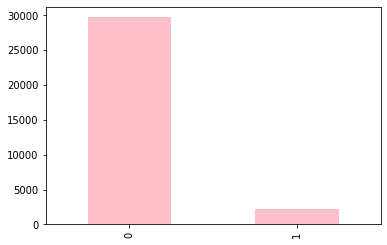

In [5]:
df['label'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))

## Train, Validation, Test Split

In [6]:
# split
x_train, x_test = train_test_split(df, test_size=0.2, random_state = 453, stratify=df['label'])
x_test, x_valid = train_test_split(x_test, test_size=0.5 , random_state = 453, stratify= x_test['label'])

y_train = x_train['label']
x_train = x_train['text']
#del x_train['label']

y_test = x_test['label']
x_test = x_test['text']
#del x_test['label']

y_valid = x_valid['label']
x_valid = x_valid['text']
#del x_valid['label']

x_train= x_train.append(x_valid, ignore_index=True)
y_train= y_train.append(y_valid, ignore_index=True)

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)
display(x_train)

(28763,)
(3196,)
(3196,)


0        @ user idea like ? muslim ban ? wall ? harassi...
1        pickin crow playing tn fitness spa , june 15th...
2        # eid sm poetry sm # masla_e_bewafa # jaun eli...
3               having nice time ðâï¸ð # lovelife
4              thankful creativity . # thankful # positive
5        amazing # tunnelview # yosemite # np # fall # ...
6        love watching cristiano ronaldo fan blame perf...
7        box , know excited # whatsinthebox # waitingfo...
8        holiday 2 day âï¸ð¹ð¨âð:copyright:â...
9        stop unfiltered feeling ! ! ! # puase-puaseð...
10       magical sugary spiderwebiness snapped elena â...
11                                       omg ð¨ sad ð
12       nice photo rebecca , capture mood , nature fai...
13       summer best worst month life . okay guess . # ...
14                      @ user bit heabreak ! # reflective
15         @ user father day legend enjoy ur special day .
16                  chick get fucked c thomas howell nak

# Training Models in a Pipeline

## Pipeline Set Up

In [7]:
# define transforms
vectorizer = TfidfVectorizer()
sampling = RandomUnderSampler(random_state=453)

# define the scoring function
f1 = make_scorer(f1_score)

# set up cross validation configuration
cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)


## Naïve Bayes

In [8]:
# Optimize parameters for NB Classifier
estimator = MultinomialNB()

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__alpha': [ 0.0001, 0.001, 0.01, 0.1, 1, 10],
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Multinomial NBClassifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_nb, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_nb, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', MultinomialNB())])
Fitting 8 folds for each of 144 candidates, totalling 1152 fits
--- 32.21951508522034 seconds ---
Multinomial NBClassifier: 46.62464138159774% F1-score for class 'hate-speech' with parameters {'estimator__alpha': 0.1, 'vectorizer__max_df': 0.25, 'vectorizer__norm': 'l1', 'vectorizer__smooth_idf': True}


['/home/v.zevallosm/detecting_harmful_content/models/English/Classical_approach/Harmful/Hyperparameters/best_parameters/nb.pkl']

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      2972
           1       0.30      0.89      0.45       224

    accuracy                           0.85      3196
   macro avg       0.65      0.87      0.68      3196
weighted avg       0.94      0.85      0.88      3196



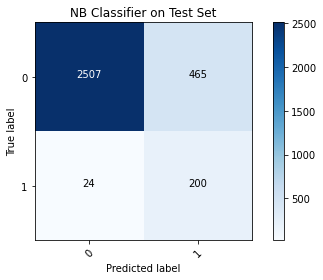

In [9]:
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "NB Classifier on Test Set")
print(classification_report(y_test, prediction))

## KNN

In [10]:
# Optimize parameters for KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
estimator = KNeighborsClassifier()

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__n_neighbors': [5, 10, 15, 20, 25],
    'estimator__weights': ['uniform','distance'],
    'estimator__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
       }

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("KNN : {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_knn, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_knn, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', KNeighborsClassifier())])
Fitting 8 folds for each of 960 candidates, totalling 7680 fits
--- 647.5202481746674 seconds ---
KNN : 47.48648056049859% F1-score for class 'hate-speech' with parameters {'estimator__algorithm': 'auto', 'estimator__n_neighbors': 15, 'estimator__weights': 'distance', 'vectorizer__max_df': 0.25, 'vectorizer__norm': 'l2', 'vectorizer__smooth_idf': True}


['/home/v.zevallosm/detecting_harmful_content/models/English/Classical_approach/Harmful/Hyperparameters/best_parameters/knn.pkl']

              precision    recall  f1-score   support

           0       0.99      0.80      0.89      2972
           1       0.25      0.88      0.39       224

    accuracy                           0.81      3196
   macro avg       0.62      0.84      0.64      3196
weighted avg       0.94      0.81      0.85      3196



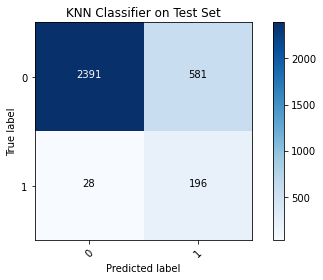

In [11]:
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "KNN Classifier on Test Set")
print(classification_report(y_test, prediction))

## Random Forest

In [12]:
# Optimize parameters for Random Forest
estimator = RandomForestClassifier( random_state=42)

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__criterion': ['gini', ' entropy'],
    'estimator__n_estimators': [100, 300, 500, 800],
    'estimator__max_depth': [5, 15, 25],
    'estimator__min_samples_split': [5, 25, 100],
    'estimator__min_samples_leaf': [ 2, 5, 10]
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Random Forest Classifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_rf, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_rf, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', RandomForestClassifier(random_state=42))])
Fitting 8 folds for each of 5184 candidates, totalling 41472 fits


/home/v.zevallosm/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.48044031 0.48209038 0.48231386 ...        nan        nan        nan]
  category=UserWarning


--- 2610.2621965408325 seconds ---
Random Forest Classifier: 53.664510776382876% F1-score for class 'hate-speech' with parameters {'estimator__criterion': 'gini', 'estimator__max_depth': 25, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 25, 'estimator__n_estimators': 500, 'vectorizer__max_df': 0.25, 'vectorizer__norm': None, 'vectorizer__smooth_idf': True}


['/home/v.zevallosm/detecting_harmful_content/models/English/Classical_approach/Harmful/Hyperparameters/best_parameters/rf.pkl']

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2972
           1       0.41      0.68      0.52       224

    accuracy                           0.91      3196
   macro avg       0.69      0.81      0.73      3196
weighted avg       0.94      0.91      0.92      3196



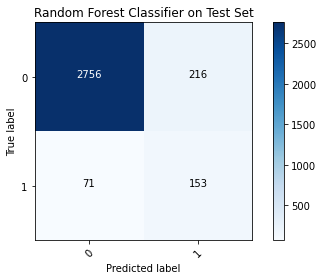

In [13]:
# Evaluate the pipeline on the test set 
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Random Forest Classifier on Test Set")
print(classification_report(y_test, prediction))


## Extra Trees

In [14]:
# Optimize parameters for Extra Trees
estimator = ExtraTreesClassifier( random_state=42)

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__criterion': ['gini', ' entropy'],
    'estimator__n_estimators': [100, 300, 500, 800],
    'estimator__max_depth': [5, 15, 25],
    'estimator__min_samples_split': [5, 25, 100],
    'estimator__min_samples_leaf': [ 2, 5, 10]
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Extra Trees Classifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_et, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_et, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', ExtraTreesClassifier(random_state=42))])
Fitting 8 folds for each of 5184 candidates, totalling 41472 fits


/home/v.zevallosm/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.48724662 0.48687269 0.49575218 ...        nan        nan        nan]
  category=UserWarning


--- 3077.390643596649 seconds ---
Extra Trees Classifier: 58.04373393709614% F1-score for class 'hate-speech' with parameters {'estimator__criterion': 'gini', 'estimator__max_depth': 25, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 25, 'estimator__n_estimators': 300, 'vectorizer__max_df': 0.5, 'vectorizer__norm': None, 'vectorizer__smooth_idf': True}


['/home/v.zevallosm/detecting_harmful_content/models/English/Classical_approach/Harmful/Hyperparameters/best_parameters/et.pkl']

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2972
           1       0.47      0.64      0.54       224

    accuracy                           0.92      3196
   macro avg       0.72      0.79      0.75      3196
weighted avg       0.94      0.92      0.93      3196



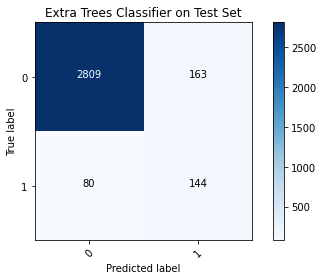

In [15]:
# Evaluate the pipeline on the test set 
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Extra Trees Classifier on Test Set")
print(classification_report(y_test, prediction))


## SGD

In [16]:
# Optimize parameters for SGDClassifier
estimator = SGDClassifier(max_iter=5000, random_state=42)

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__loss': ['hinge','modified_huber','perceptron','squared_hinge'],
    'estimator__alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
    'estimator__tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("SGDClassifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_sgd, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_sgd, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', SGDClassifier(max_iter=5000, random_state=42))])
Fitting 8 folds for each of 4608 candidates, totalling 36864 fits
--- 960.9412705898285 seconds ---
SGDClassifier: 57.91925381671397% F1-score for class 'hate-speech' with parameters {'estimator__alpha': 0.001, 'estimator__loss': 'hinge', 'estimator__tol': 0.01, 'vectorizer__max_df': 0.25, 'vectorizer__norm': 'l2', 'vectorizer__smooth_idf': False}


['/home/v.zevallosm/detecting_harmful_content/models/English/Classical_approach/Harmful/Hyperparameters/best_parameters/sgd.pkl']

              precision    recall  f1-score   support

           0       0.98      0.93      0.96      2972
           1       0.45      0.72      0.56       224

    accuracy                           0.92      3196
   macro avg       0.72      0.83      0.76      3196
weighted avg       0.94      0.92      0.93      3196



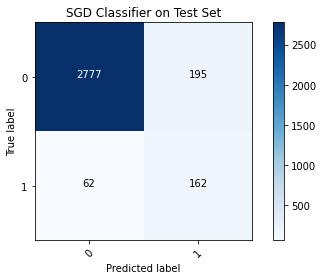

In [17]:
# Evaluate the pipeline on the test set 
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "SGD Classifier on Test Set")
print(classification_report(y_test, prediction))


## SVM

In [18]:
# Optimize parameters for LSVM Classifier
estimator = LinearSVC(max_iter=5000, random_state=42, dual = True)

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__loss': ['hinge', 'squared_hinge'],
    'estimator__tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    'estimator__C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("LSVM Classifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_svm, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_svm, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', LinearSVC(max_iter=5000, random_state=42))])
Fitting 8 folds for each of 1680 candidates, totalling 13440 fits
--- 489.33466124534607 seconds ---
LSVM Classifier: 57.957238124286384% F1-score for class 'hate-speech' with parameters {'estimator__C': 0.1, 'estimator__loss': 'hinge', 'estimator__tol': 0.001, 'vectorizer__max_df': 0.25, 'vectorizer__norm': 'l2', 'vectorizer__smooth_idf': False}


['/home/v.zevallosm/detecting_harmful_content/models/English/Classical_approach/Harmful/Hyperparameters/best_parameters/svm.pkl']

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2972
           1       0.51      0.62      0.56       224

    accuracy                           0.93      3196
   macro avg       0.74      0.79      0.76      3196
weighted avg       0.94      0.93      0.93      3196



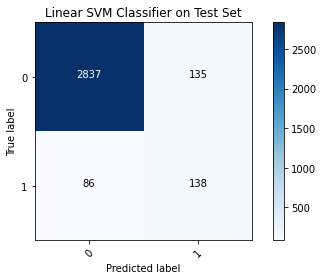

In [19]:
# Evaluate the pipeline on the test set 
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Linear SVM Classifier on Test Set")
print(classification_report(y_test, prediction))


## Logistic Regression

In [20]:
# Optimize parameters for Logistic Regression
estimator = LogisticRegression()

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__penalty': [ 'l2', 'none'],
    'estimator__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'estimator__C': [100, 10, 1.0, 0.1, 0.01]
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Logistic Regression Classifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_lr, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_lr, compress = 1) # Only best parameters

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', LogisticRegression())])
Fitting 8 folds for each of 1200 candidates, totalling 9600 fits


/home/v.zevallosm/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.49425141 0.49602674 0.49540148 ... 0.49242296 0.47095475 0.47240521]
  category=UserWarning


--- 360.91219186782837 seconds ---
Logistic Regression Classifier: 56.539375764462484% F1-score for class 'hate-speech' with parameters {'estimator__C': 0.01, 'estimator__penalty': 'l2', 'estimator__solver': 'newton-cg', 'vectorizer__max_df': 0.25, 'vectorizer__norm': None, 'vectorizer__smooth_idf': False}


['/home/v.zevallosm/detecting_harmful_content/models/English/Classical_approach/Harmful/Hyperparameters/best_parameters/lr.pkl']

              precision    recall  f1-score   support

           0       0.98      0.91      0.95      2972
           1       0.41      0.80      0.54       224

    accuracy                           0.91      3196
   macro avg       0.70      0.86      0.75      3196
weighted avg       0.94      0.91      0.92      3196



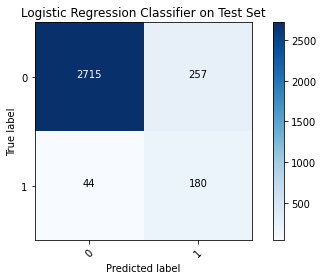

In [21]:
# Evaluate the pipeline on the test set 
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Logistic Regression Classifier on Test Set")
print(classification_report(y_test, prediction))

## Decision Tree

In [22]:
# Optimize parameters for simple Decision Tree
estimator = DecisionTreeClassifier(random_state=101)

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.3, 0.6, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__splitter' : ['best', 'random'],
    'estimator__max_depth': [5, 15, 25],
    'estimator__min_samples_split': [5, 25, 100],
    'estimator__min_samples_leaf': [ 2, 5, 10]
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Decision Tree Classifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_dt, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_dt, compress = 1) # Only best parameters

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', DecisionTreeClassifier(random_state=101))])
Fitting 8 folds for each of 972 candidates, totalling 7776 fits
--- 214.83138275146484 seconds ---
Decision Tree Classifier: 47.05290651420339% F1-score for class 'hate-speech' with parameters {'estimator__max_depth': 25, 'estimator__min_samples_leaf': 10, 'estimator__min_samples_split': 5, 'estimator__splitter': 'best', 'vectorizer__max_df': 0.3, 'vectorizer__norm': 'l1', 'vectorizer__smooth_idf': True}


['/home/v.zevallosm/detecting_harmful_content/models/English/Classical_approach/Harmful/Hyperparameters/best_parameters/dt.pkl']

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2972
           1       0.45      0.53      0.49       224

    accuracy                           0.92      3196
   macro avg       0.71      0.74      0.72      3196
weighted avg       0.93      0.92      0.92      3196



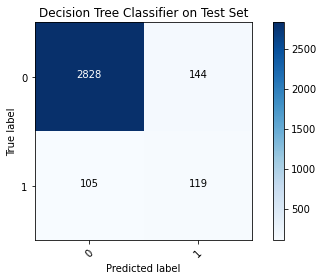

In [23]:
# Evaluate the pipeline on the test set 
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "Decision Tree Classifier on Test Set")
print(classification_report(y_test, prediction))